# Lab 2: RCT vs Observational data</font>


Exercise 1

We will perform the same simulations proposed in Lunceford & Davidian 2004.

## Generative model

The *response* variable $Y$ is generated according the following equation:
$$  Y = {\nu}_{0} +{\nu}_{1}X_1 +{\nu}_{2}X_2 +{\nu}_{3}X_3 +{\nu}_{4}A+{\xi}_{1}V_1 +{\xi}_{2}V_2 +{\xi}_{3}V_3 + \epsilon, \epsilon \sim \mathcal{N}(0 ,1),$$
where $\nu = {\left({\nu}_{0}, {\nu}_{1}, {\nu}_{2}, {\nu}_{3}, {\nu}_{4}\right)}^{\top} = {\left(0, -1, 1, -1, 2\right)}^{\top}$, $\xi = {\left({\xi}_{1}, {\xi}_{2}, {\xi}_{3}\right)}^{\top} = {\left(-1, 1, 1\right)}^{\top}$. The *covariates* are distributed as
$X_3 \sim \text{Bernoulli}\left(0.2\right)$, and conditionnaly on $X_3$


$\text{If } X_{3} = 0$, $V_3 \sim \text{Bernoulli}\left(0.25\right)$ and
 ${\left(X_{1}, V_{1}, X_{2}, V_{2}\right)}^{\top} \sim \mathcal{N}({\tau}_{0}, \Sigma)$

$\text{If } X_{3} = 1$, $V_3 \sim  \text{Bernoulli}\left(0.75\right)$ and ${\left(X_{1}, V_{1}, X_{2}, V_{2}\right)}^{\top} \sim \mathcal{N}({\tau}_{1}, \Sigma)$
with
$$ {\tau}_{1} = \left(\begin{array}{c}
1 \\
1 \\
-1\\
-1
\end{array}\right), {\tau}_{0} = \left(\begin{array}{c}
-1 \\
-1 \\
1\\
1
\end{array}\right), \text{and}, \Sigma = \left(\begin{array}{cccc}
1 & 0.5 & -0.5 & -0.5\\
0.5 & 1 & -0.5 & -0.5  \\
-0.5 & -0.5 & 1 & 0.5 \\
-0.5 & -0.5 & 0.5 & 1
\end{array}
\right)$$

and the *treatment* $A$ is generated as a Bernoulli of the *propensity score*
$$e\left(X, \beta\right) = {\{1+\exp\left(- {\beta}_{0} - {\beta}_{1}X_{1} - {\beta}_{2}X_{2} - {\beta}_{3}X_{3}\right)\}}^{-1}$$
with $\beta={\left({\beta}_{0}, {\beta}_{1}, {\beta}_{2}, {\beta}_{3}\right)}^{\top} = {\left(0, 0.6, -0.6, 0.6\right)}^{\top}$.


In [2]:
# Processing
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns

# Prediction
import sklearn.ensemble as sklearn_ensemble
import sklearn.linear_model as sklearn_linear_model
import statsmodels.api as sm

# Plot
sns.set(font_scale=1.5)
DIST_CAT_PLOT_PARAMS_D = {"height": 14, "aspect": .8}

In [3]:
# Model parameters
XI = np.array([-1, 1, 1])
NU = np.array([0, -1, 1, -1, 2])
BETA = np.array([0, 0.6, -0.6, 0.6])
TAU_0 = np.array([-1, -1, 1, 1])
TAU_1 = TAU_0 * -1
SIGMA = np.array([[1, 0.5, -0.5, -0.5],
                  [0.5, 1, -0.5, -0.5],
                  [-0.5, -0.5, 1, 0.5],
                  [-0.5, -0.5, 0.5, 1]], dtype=float)


In [4]:
def generate_lunceford(n=1000):
    # Generate data
    x3 = np.random.binomial(1, 0.2, n)
    v3 = np.random.binomial(1, (0.75 * x3 + (0.25 * (1 - x3))), n)

    # If x3=0 you have a model, if x3=1 you have another one
    x1v1x2v2_x3_0_matrix = np.random.multivariate_normal(TAU_0, SIGMA, size=n, check_valid='warn', tol=1e-8)
    x1v1x2v2_x3_1_matrix = np.random.multivariate_normal(TAU_1, SIGMA, size=n, check_valid='warn', tol=1e-8)
    x1v1x2v2_x3 = np.where(np.repeat(x3[:, np.newaxis], 4, axis=1) == 0, x1v1x2v2_x3_0_matrix, x1v1x2v2_x3_1_matrix)

    # Concatenate values
    xv = np.concatenate([x1v1x2v2_x3, np.expand_dims(x3, axis=1), np.expand_dims(v3, axis=1)], axis=1)

    # Compute e, a, and y
    x = xv[:, [0,2,4]]
    v = xv[:, [1,3,5]]
    e = np.power(1 + np.exp(- BETA[0] - x.dot(BETA[1:])), -1)
    a = np.random.binomial(1, e, n)
    y = x.dot(NU[1:-1]) + v.dot(XI) + a*NU[-1] + np.random.binomial(1, e, n) + np.random.normal(0, 1, n)

    # Create the final df
    synthetic_data_df = pd.DataFrame(np.concatenate([x, np.expand_dims(a, axis=1), v, np.expand_dims(y, axis=1), np.expand_dims(e, axis=1)], axis=1), columns=["X1", "X2", "X3", "A", "V1", "V2", "V3", "Y", "e"])
    synthetic_data_df["A"] = synthetic_data_df["A"].astype(int)

    return synthetic_data_df

In [5]:
simul_pe_data = generate_lunceford(n = 5000)
simul_pe_data.describe()

,X1,X2,X3,A,V1,V2,V3,Y,e
count,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,-0.596717,0.601337,0.20320,0.390400,-0.600026,0.589411,0.349200,3.682701,0.381162
std,1.293656,1.281138,0.40242,0.487889,1.303654,1.274618,0.476765,4.141852,0.280098
min,-4.506396,-3.738196,0.00000,0.000000,-5.335590,-4.346886,0.000000,-12.529105,0.005513
25%,-1.504890,-0.213582,0.00000,0.000000,-1.505684,-0.232397,0.000000,1.172415,0.152611
50%,-0.715478,0.706013,0.00000,0.000000,-0.713319,0.697176,0.000000,4.129277,0.293757
75%,0.222954,1.513418,0.00000,1.000000,0.217655,1.505480,1.000000,6.556572,0.568814
max,3.969824,4.766495,1.00000,1.000000,4.321073,4.548946,1.000000,16.563996,0.992353


# Exercise 2

![alt text](<Screenshot 2024-06-20 120628.png>)

In [6]:
df = pd.read_csv(fr'C:\Users\belen\Desktop\Université de Lorraine\Second semester\Machine_learning\Lab_6\ihdp_npci.csv')

In [7]:
# Asignar nombres a las columnas
columns = ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [f"x{i}" for i in range(1, 26)]
df.columns = columns

# Verificar los nombres de las columnas
print(df.head())


   treatment  y_factual  y_cfactual       mu0       mu1        x1        x2  \
0          0   6.875856    7.856495  6.636059  7.562718 -1.736945 -1.802002   
1          0   2.996273    6.633952  1.570536  6.121617 -0.807451 -0.202946   
2          0   1.366206    5.697239  1.244738  5.889125  0.390083  0.596582   
3          0   1.963538    6.202582  1.685048  6.191994 -1.045229 -0.602710   
4          0   4.762090    8.264795  4.707898  7.219442  0.467901 -0.202946   

         x3        x4        x5  ...  x16  x17  x18  x19  x20  x21  x22  x23  \
0  0.383828  2.244320 -0.629189  ...    1    1    1    1    0    0    0    0   
1 -0.360898 -0.879606  0.808706  ...    1    0    1    1    0    0    0    0   
2 -1.850350 -0.879606 -0.004017  ...    1    0    1    1    0    0    0    0   
3  0.011465  0.161703  0.683672  ...    1    1    1    1    0    0    0    0   
4 -0.733261  0.161703  0.058500  ...    1    1    1    1    0    0    0    0   

   x24  x25  
0    0    0  
1    0    0  
2 

1. Create a causal model from the data and given common causes using the function
CausalModel.

c:\Users\belen\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


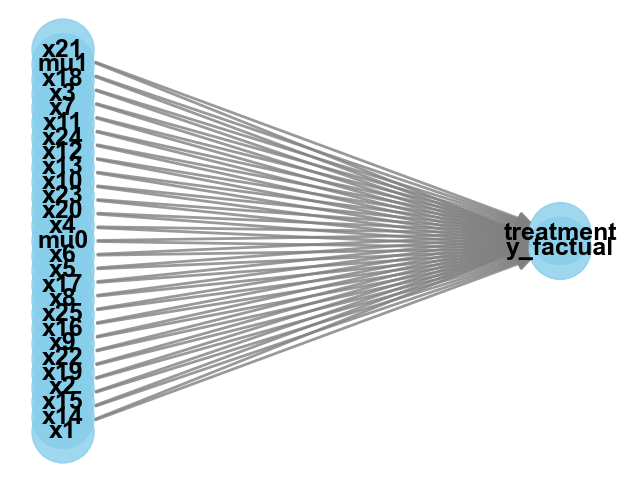

Causal model created.


In [8]:
from dowhy import CausalModel

# Definir las causas comunes conocidas
common_causes = ["mu0", "mu1"] + [f"x{i}" for i in range(1, 26)]

# Crear un modelo causal
causal_model = CausalModel(
    data=df,
    treatment="treatment",
    outcome="y_factual",
    common_causes=common_causes
)

# Visualizar el gráfico causal
causal_model.view_model()
print("Causal model created.")


2. Identify the causal effect using the function identify effect

In [9]:
identified_estimand = causal_model.identify_effect()
print(identified_estimand)


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(E[y_factual|x1,x14,x15,x2,x19,x22,x9,x16,x25,x8,x17,x5,x6,mu0,x4,
d[treatment]                                                                  

                                               
x20,x23,x10,x13,x12,x24,x11,x7,x3,x18,mu1,x21])
                                               
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→y_factual then P(y_factual|treatment,x1,x14,x15,x2,x19,x22,x9,x16,x25,x8,x17,x5,x6,mu0,x4,x20,x23,x10,x13,x12,x24,x11,x7,x3,x18,mu1,x21,U) = P(y_factual|treatment,x1,x14,x15,x2,x19,x22,x9,x16,x25,x8,x17,x5,x6,mu0,x4,x20,x23,x10,x13,x12,x24,x11,x7,x3,x18,mu1,x21)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



3. We shall now estimate the causal effect comparing different methods

(a) Estimate the causal effect and compare it with Average Treatment Effect using
linear regression

In [14]:
from dowhy import CausalModel
import statsmodels.api as sm

# Variables dependiente e independiente
X = df[['treatment'] + common_causes]
y = df['y_factual']

# Agregar una constante
X = sm.add_constant(X)

# Ajustar el modelo de regresión lineal
linear_model = sm.OLS(y, X).fit()

# Calcular el ATE
ate_linear_regression = linear_model.params['treatment']
print(f"ATE using linear regression: {ate_linear_regression}")


ATE using linear regression: 4.003415074671419


(b) Estimate the causal effect and compare it with Average Treatment Effect using
propensity score matching

In [15]:
from sklearn.linear_model import LogisticRegression

# Definir el modelo de regresión logística para calcular las puntuaciones de propensión
ps_model = LogisticRegression()

# Las causas comunes se definen en una lista
common_causes = ["mu0", "mu1"] + [f"x{i}" for i in range(1, 26)]

# Ajustar el modelo de regresión logística
ps_model.fit(df[common_causes], df['treatment'])

# Calcular las puntuaciones de propensión
df['propensity_score'] = ps_model.predict_proba(df[common_causes])[:, 1]

print("Propensity scores calculated.")


Propensity scores calculated.


In [16]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

# Realizar el emparejamiento utilizando las puntuaciones de propensión
treated = df[df['treatment'] == 1]
control = df[df['treatment'] == 0]

# Usar NearestNeighbors para encontrar el control más cercano para cada tratado
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Crear un DataFrame emparejado
matched_control = control.iloc[indices.flatten()]
df_matched = pd.concat([treated, matched_control])

print("Propensity score matching completed.")


Propensity score matching completed.


In [17]:
# Estimar el ATE utilizando el conjunto emparejado
ate_psm = np.mean(df_matched[df_matched['treatment'] == 1]['y_factual']) - np.mean(df_matched[df_matched['treatment'] == 0]['y_factual'])

print(f"ATE using propensity score matching: {ate_psm}")


ATE using propensity score matching: 4.086743030144441


4. Refute the obtained estimate using multiple robustness checks.

(a) Adding a random common cause

In [18]:
import numpy as np
import statsmodels.api as sm

# Agregar una causa común aleatoria
np.random.seed(42)
df['random_common_cause'] = np.random.randn(len(df))

# Reajustar el modelo de regresión lineal con la nueva causa común
X_random = df[['treatment', 'random_common_cause'] + common_causes]
X_random = sm.add_constant(X_random)

# Ajustar el modelo de regresión lineal
linear_model_random = sm.OLS(df['y_factual'], X_random).fit()

# Calcular el ATE
ate_linear_regression_random = linear_model_random.params['treatment']
print(f"ATE using linear regression with random common cause: {ate_linear_regression_random}")


ATE using linear regression with random common cause: 4.009252346557887


(b) Using a placebo treatment

In [19]:
# Crear una columna de tratamiento placebo
df['placebo_treatment'] = np.random.permutation(df['treatment'])

# Reajustar el modelo de regresión lineal con el tratamiento placebo
X_placebo = df[['placebo_treatment'] + common_causes]
X_placebo = sm.add_constant(X_placebo)

# Ajustar el modelo de regresión lineal
linear_model_placebo = sm.OLS(df['y_factual'], X_placebo).fit()

# Calcular el ATE
ate_linear_regression_placebo = linear_model_placebo.params['placebo_treatment']
print(f"ATE using linear regression with placebo treatment: {ate_linear_regression_placebo}")


ATE using linear regression with placebo treatment: 0.017162430165870712
